In [3]:
from sqlalchemy import or_, func
from sqlalchemy.orm import sessionmaker
from HardwareSwap.Models import Base, engine, Post, PostType, get_or_create, Series, Manufacturer, Brand, GPU, PostBrand, PostManufacturer
import tqdm

In [4]:
recreate = False
if recreate:
    Base.metadata.drop_all(engine)
Base.metadata.create_all(engine)
Session = sessionmaker(bind = engine)

In [5]:
s = Session()
buying = get_or_create(s, PostType, post_type="buying")
selling = get_or_create(s, PostType, post_type="selling")
trading = get_or_create(s, PostType, post_type="trading")
giveaway = get_or_create(s, PostType, post_type="giveaway")
meta = get_or_create(s, PostType, post_type="meta")
official = get_or_create(s, PostType, post_type="official")
alert = get_or_create(s, PostType, post_type="alert")


In [6]:
%load_ext autoreload
%autoreload 1
%aimport HardwareSwap
%aimport HardwareSwap.DownloadData
%aimport HardwareSwap.DownloadData.download_data
from HardwareSwap.DownloadData import download_data, remove_duplicate_rows
import os
import datetime
import pytz
import pandas as pd
from HardwareSwap.Models.Post import get_regex_to_parse_title
import re
import json
import matplotlib.pyplot as plt

In [7]:
data_root = "/home/neil/hardwareswap/raw_data/"
pcpartpicker_gpu_dir = os.path.join(data_root, "pcpartpicker_gpu")
raw_data = download_data.load_dataframe_from_disk(os.path.join(data_root, "reddit_posts", "data_*-*.json"), limit=1)

print(f"Found {len(raw_data)} posts")
Post.create_bulk(raw_data, s)
Post.clean(s)

Found 100 posts


0it [00:00, ?it/s]


Inserting 0 items... Done!


KeyboardInterrupt: 

In [8]:
s.rollback()

In [9]:

pcpartpicker_gpus_fname = os.path.join(pcpartpicker_gpu_dir, "pcpartpicker_gpu.json")
if os.path.isfile(pcpartpicker_gpus_fname):
    with open(pcpartpicker_gpus_fname, 'r') as fp:
        gpus_all = json.load(fp)

In [10]:
pcpartpicker_gpus_fname

'/home/neil/hardwareswap/raw_data/pcpartpicker_gpu/pcpartpicker_gpu.json'

In [11]:
df = pd.DataFrame(gpus_all)
df["chipset"] = df.apply(lambda x: x["chipset"].replace("Chipset",""), axis=1)
df["brand"] = ""
df["mfg"] = ""

# set the brands
df.at[df["chipset"].str.contains("GeForce"), "brand"] = "nvidia"
df.at[df["chipset"].str.contains("Quadro"), "brand"] = "nvidia"
df.at[df["chipset"].str.contains("NVS"), "brand"] = "nvidia"
df.at[df["chipset"].str.contains("RTX"), "brand"] = "nvidia"
df.at[df["chipset"].str.contains("Titan"), "brand"] = "nvidia"
df.at[df["chipset"].str.contains("Radeon"), "brand"] = "amd"
df.at[df["chipset"].str.contains("FirePro"), "brand"] = "amd"
df.at[df["chipset"].str.contains("Vega"), "brand"] = "amd"
df.at[df["chipset"].str.contains("FireGL"), "brand"] = "amd"

# manufacture
brands = ["Sapphire","Asus","Gigabyte","EVGA","MSI","PNY","Zotac", "Lenovo", "GALAX","Inno3D","Jaton Video",
          "Galaxy","Sparkle", "ECS","Palit","KFA2" ,"OcUK","Gainward","XFX","BFG","NVIDIA","HP","Leadtek",
          "Zogis","Colorful","Biostar","Corsair","Dell", "HIS", "PowerColor", "VisionTek","Diamond", "Club 3D", "ASRock", "ATI","AMD", "Yeston"]
for brand in brands:
    df.at[df["name"].str.contains(brand), "mfg"] = brand.lower()


# Extract information about the gpus
result_names=["series","prefix","number","variant"]
for col in result_names:
    df[col] = ""
f_geforce = re.compile("(?P<series>(?:GeForce))?\s?(?P<prefix>(?:GTX)|(?:RTX)|(?:GT)|(?:GTS))\s?(?P<number>[123]?[0245679][1-9]0)\s?(?P<variant>(?:Ti|m))?")
f_quadro = re.compile("(?P<series>(?:Quadro))?\s?(?P<prefix>[KMP])\s?(?P<number>[12345678][02]0{2})\s?(?P<variant>(?:D))?")
f_titan = re.compile("(?P<series>(?:GeForce))?\s?(?P<prefix>(?:GTX)|(?:RTX))\s?(?P<number>(?:Titan))\s?(?P<variant>(?:Z)|(?:X)|(?:Black))?")
f_radeon = re.compile("(?P<series>(?:Radeon Pro)|(?:Radeon))\s?(?P<prefix>(?:RX)|(?:R[579])|(?:HD)|(?:WX))?\s?(?P<number>(?:[34567]?[123456789][03456789][05])|(?:Fury)|(?:VEGA [56][46])|(?:Nano)|(?:VII))?\s?(?P<variant>(?:X2)|(?:XT)|(?:X))?")
f_firepro = re.compile("(?P<series>(?:FirePro)|(?:FireGL))\s?(?P<prefix>(?:[VWRS][G]?))?\s?(?P<number>(?:[2345789]?[012346789][02567]0))\s?(?P<variant>(?:A?))?")
f_vega = re.compile("(?P<series>(?:Vega))\s?(?P<prefix>)?\s?(?P<number>)\s?(?P<variant>(?:Frontier Edition Liquid)|(?:Frontier Edition))")

for idx in range(len(df)):
    chipset = df.at[idx, "chipset"]
    for regex_function in [f_geforce, f_quadro, f_titan, f_radeon, f_firepro, f_vega]:
        match = regex_function.match(chipset)
        if match is None:
            continue
        series,prefix,number,variant = match.group(*result_names)
        df.at[idx,"series"] = series if not None else ""
        df.at[idx,"prefix"] = prefix if not None else ""
        df.at[idx,"number"] = number if not None else ""
        df.at[idx,"variant"] = variant if not None else ""
        break

#df[(df["brand"]=="nvidia") & (df["model"]=="")]
df[(df["brand"]=="amd" ) & (df["number"]=="")]


,name,chipset,price,url,brand,mfg,series,prefix,number,variant
3376,AMD 100-506061,Vega Frontier Edition,1750.00,/product/mCH48d/amd-vega-frontier-edition-air-...,amd,amd,Vega,,,Frontier Edition
4218,AMD 100-506062,Vega Frontier Edition Liquid,0,/product/8QrcCJ/amd-vega-frontier-edition-liqu...,amd,amd,Vega,,,Frontier Edition Liquid


In [12]:
def geforce_series(row):
    if row["series"] != "GeForce":
        return ""
    if not row["number"].isnumeric():
        return ""
    scale = 100
    series = f"GeForce {int(int(row['number'])/scale)}"
    return series

def get_vendor_series(row):
    if row["series"] == "GeForce":
        return geforce_series(row)

df["Vendor Series"] = df.apply(lambda row: geforce_series(row), axis=1)

series = {}
for item in df["Vendor Series"].unique():
    if item == "":
        continue
    elif item is None:
        continue
    series[item] = get_or_create(s,  Series, series=item)
    
mfgs = {}
for item in df["mfg"].unique():
    if item == "":
        continue
    elif item is None:
        continue
    mfgs[item] = get_or_create(s,  Manufacturer, manufacturer=item)

brands = {}
for item in df["brand"].unique():
    if item == "":
        continue
    elif item is None:
        continue
        
    brands[item] = get_or_create(s,  Brand, brand=item)
    

In [13]:
s.rollback()
gpus = []
for idx in range(len(df)):
    row = df.iloc[idx]
    price = None
    if row["price"] != "0":
        price = float(row["price"])
    try:
        gpu = GPU(
            name = row["name"],
            brand_id = brands[row["brand"]].id,
            manufacturer_id = mfgs[row["mfg"]].id,
            series_id = series[row["Vendor Series"]].id,
            chipset = row["chipset"],
            prefix = row["prefix"],
            number = int(row["number"]),
            pcpartpicker_url = row["url"],
            pcpartpicker_price = price,       
                )
        gpus.append(gpu)
    except KeyError:
        pass
s.bulk_save_objects(gpus)
s.commit()
    

In [19]:
f_geforce = re.compile("(?P<series>(?:GeForce))?\s?"\
                       "(?P<prefix>(?:GTX)|(?:RTX)|(?:GT)|(?:GTS))\s?"\
                       "(?P<number>[123]?[0245679][1-9]0)\s?"\
                       "(?P<variant>(?:Ti|m))?\s?"\
                       "(?P<edition>(?:FE))?"\
                       ".{0,100}?"+ # consume as few characters as possible to the first price
                       "(?P<price>\$(?:\d{1,3},?)(?:\d{1,3})(?:\.\d\d)?)" + # Prices must start with '$'. Max price is 999,999.99.  Does not need decimals. Can contain ',' as a thousands separator
                       "(?P<price_external>(?:.{0,100})(?:\@.{0,100}))?", # Try and determine if the detected price is coming from some external source (ie referenceing PC Part Picker)
                      re.IGNORECASE)

match_count = 0
matching_posts = []
for item in (
        s.query(Post.id, Post.have, Post.selftext, Post.created_utc)
            #.join(PostManufacturer, Post.id==PostManufacturer.post_id)
            #.join(Manufacturer, PostManufacturer.manufacturer_id==Manufacturer.id)
            #.filter(Manufacturer.manufacturer=="nvidia")
            .filter(Post.post_type_id==2)
            .order_by(Post.created_utc)
            #.limit(2000)
            .all()
        ):
    if item[2] is None:
        continue
    match_count += 1
    matches = f_geforce.findall(item[2])
    #print(item[1])
    if len(matches)==0:
        continue
    #print(f"Found {len(matches)} matches in\n{item[2]}:")
    for m in matches:
        matching_posts.append({"post_id":item[0], "created":item[3], "number":m[2], "variant":m[3], "price":float(m[5].strip("$").replace(",","")), "price_external":m[6]})
        #print(f"\t{item[3]} {m}")
        
    #print("-"*50)
    #if len(matches) == 3:
    #    break

In [20]:
cards = pd.DataFrame(matching_posts)
cards.sort_values("created", inplace=True)
cards.reset_index(inplace=True, drop=True)
print(len(cards))

12137


In [21]:
plt.rcParams["figure.figsize"] = [20,10]
matching_query = cards[(cards["number"]=="2080") & (cards["variant"]=="Ti") & (cards["price_external"]=="")]
#plt.plot(matching_query["created"], matching_query["price"])

matching_query = cards[(cards["number"]=="2080") & (cards["variant"]=="") & (cards["price_external"]=="")]
#plt.plot(matching_query["created"], matching_query["price"])



Mean and std used: 340.66 187.86
Mean and std new : 317.06 95.43


(0, 1500)

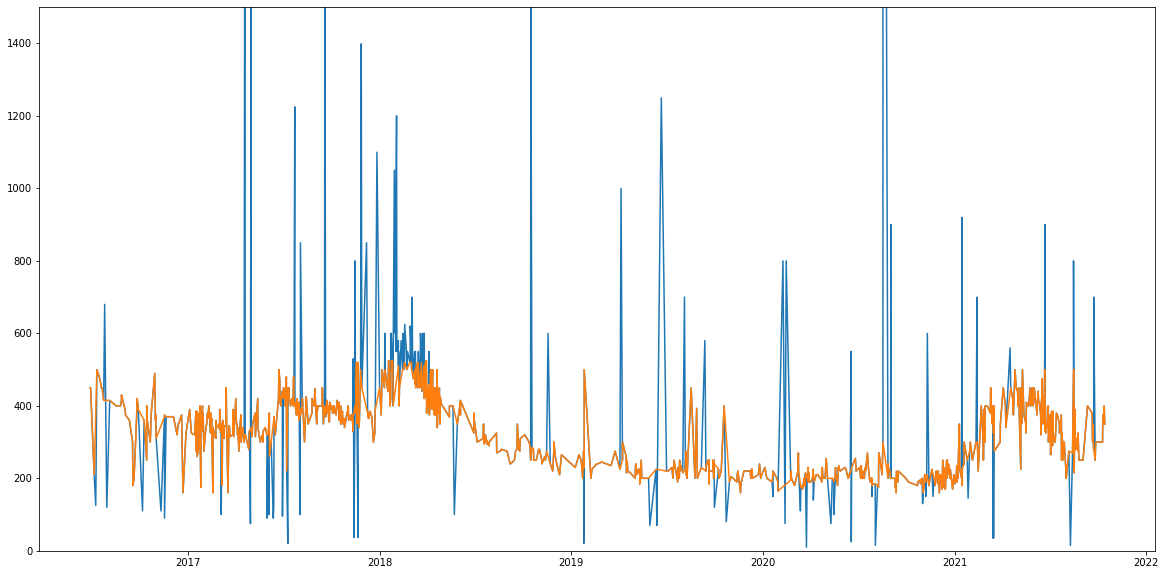

In [24]:
matching_query = cards[(cards["number"]=="1070") & (cards["variant"]=="") & (cards["price_external"]=="")]

std = matching_query["price"].std()
mean = matching_query["price"].mean()
price_min = mean - std
price_max = mean + std


matching_query_filtered = matching_query[(matching_query["price"]>=price_min) & (matching_query["price"]<=price_max) ]

print(f"Mean and std used: {mean:.2f} {std:.2f}")
print(f"Mean and std new : {matching_query_filtered['price'].mean():.2f} { matching_query_filtered['price'].std():.2f}")

plt.plot(matching_query["created"], matching_query["price"])
plt.plot(matching_query_filtered["created"], matching_query_filtered["price"])
plt.ylim((0,1500))

In [50]:
matching_query[(matching_query["price"]>100) & (matching_query["price"]<200) ]# & (matching_query["created"]>datetime.datetime(year=2019, month=7, day=1))]

,post_id,created,number,variant,price,price_external
16427,ili56v,2020-09-02 23:28:47,3070,,150.0,
17183,jn4q5z,2020-11-03 05:32:33,3070,,150.0,
17592,jy33dc,2020-11-21 02:43:13,3070,,190.0,
17593,jy33dc,2020-11-21 02:43:13,3070,,180.0,
17614,jypcbl,2020-11-22 04:14:24,3070,,190.0,
17615,jypcbl,2020-11-22 04:14:24,3070,,180.0,
18370,kfselb,2020-12-18 19:58:31,3070,,180.0,
18880,kqq1fq,2021-01-05 04:00:56,3070,,150.0,
19777,lj70n9,2021-02-13 19:15:07,3070,,175.0,
21233,n9drlp,2021-05-10 19:28:19,3070,,180.0,


In [51]:
print(s.query(Post).get("jypcbl").selftext)

 

This is a repost since I have one slight change with the info.

Looking to trade an RTX 3080 FE (Used approximately 3 weeks **and 1 day now**) for one of the following RTX 3070 + cash only

EVGA RTX 3070 XC3 Black + $190 cash

ASUS RTX 3070 TUF + $180 cash

RTX 3070 FE + $220 cash

**Other 3070 card that does not reach $560 MAY also work but the above are the preferable one**

Will not accept any 3070 above 560$, so don't have to come with those FTW3 or anything, my friend won't want them, period.

**MAY because I will be looking to trade a 3070 for my friend and not myself** 

**Both COD and WL are redeemed on this GPU so this 3080 FE won't be able to redeem any pre-order games**

**Still comes with 1 year GeForce** 

**ZIP is 60616 in the Chicago area, will not do shipping (sorry) even if offer $1000+ since I been hard scam b4**

**Thanks. reply here b4 pm me**

Timestamp: [https://imgur.com/a/6SESAse](https://imgur.com/a/6SESAse)


In [20]:
matching_query[matching_query["post_id"]=="dcyhwu"]

,post_id,created,number,variant,price,price_external
